# Moral Ground Clustering

## Data loading

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import re

In [2]:
with open(os.getcwd()+'/data/reddit-morality/SubIDs__(Sub_AITA)__(Redditor_active).pkl', 'rb') as f:
    all_ids = pickle.load(f)
    
with open(os.getcwd()+'/data/reddit-morality/Situations__(Sub_AITA)__(Redditor_active).pkl', 'rb') as f:
    all_situations = pickle.load(f)

with open(os.getcwd()+'/data/reddit-morality/SituationEncoding__(Sub_AITA)__(Redditor_active)__sbert.npy', 'rb') as f:
    situ_reps = np.load(f)

## Perform clustering

In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

### Find PC and K value

In [4]:
data = situ_reps[:]

pca = PCA()
pca.fit(data)

PCA()

70 percent coverage at 73
80 percent coverage at 112
90 percent coverage at 180
95 percent coverage at 237
99 percent coverage at 317


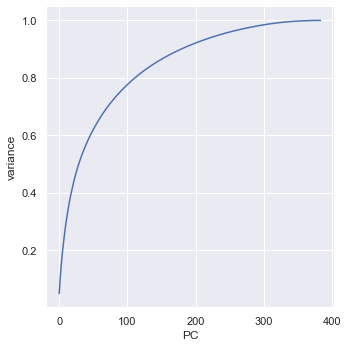

In [5]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
coverage_goal, desired_pc = 0.8, 0

for coverage in [0.7, 0.8, 0.9, 0.95, 0.99]:
    if coverage == coverage_goal:
        desired_pc = np.argmax(cumsum >= coverage) + 1
    print("%d percent coverage at %d"%(coverage*100, np.argmax(cumsum >= coverage) + 1))

sns.set_theme(style="darkgrid")
sns.relplot(x="PC", y="variance", sort=False, kind="line", data=pd.DataFrame({'PC':range(cumsum.shape[0]), 'variance':cumsum}))

In [6]:
n_pca_components = desired_pc

pca_pc = PCA(n_components=1+n_pca_components)
pca_data = pca_pc.fit_transform(data)[:, list(range(1,n_pca_components+1))]
distorsions = []
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_data)
    distorsions.append(kmeans.inertia_)

100%|██████████| 48/48 [09:03<00:00, 11.33s/it]


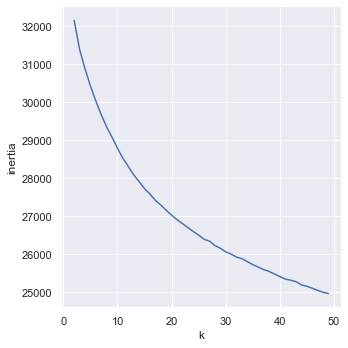

In [7]:
sns.relplot(x="k", y="inertia", sort=False, kind="line", data=pd.DataFrame({'k':range(2, 50), 'inertia':distorsions}))

### KMeans

In [4]:
n_kmeans_clusters = 20
data = situ_reps[:]

kmeans = KMeans(n_clusters = n_kmeans_clusters, random_state=624)
kmeans.fit(data)

KMeans(n_clusters=20, random_state=624)

### Analyzing the cluster results

In [5]:
clusterIdx_to_IDs = {key:[] for key in range(n_kmeans_clusters)}

clusterIdx_to_situations = {key:[] for key in range(n_kmeans_clusters)}
clusterIdx_to_situationReps = {key:[] for key in range(n_kmeans_clusters)}
clusterIdx_to_situationIdx = {key:[] for key in range(n_kmeans_clusters)}


for situ_idx, cluster_idx in enumerate(kmeans.labels_):
    
    clusterIdx_to_IDs[cluster_idx].append(all_ids[situ_idx])
    
    clusterIdx_to_situations[cluster_idx].append(all_situations[situ_idx])
    clusterIdx_to_situationReps[cluster_idx].append(data[situ_idx])
    clusterIdx_to_situationIdx[cluster_idx].append(situ_idx)
        
# pickle.dump(clusterIdx_to_situationIdx, open(os.getcwd()+'/data/reddit-morality/clusterIdx_to_situationIdx.pkl', 'wb'))
# pickle.dump(clusterIdx_to_IDs, open(os.getcwd()+'/data/reddit-morality/clusterIdx_to_IDs.pkl', 'wb'))

In [39]:
kmeans_closest, _ = metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_, data)


for idx, elem in enumerate(kmeans_closest):
    _sents = ['CLUSTER: '+str(idx), '\nCENTROID: '+all_situations[elem], '\n']
    
    _dists = metrics.pairwise_distances(np.reshape(kmeans.cluster_centers_[idx],(1,data[0].shape[-1])), 
                                        np.array(clusterIdx_to_situationReps[idx]))

    _dists_sorted = sorted(enumerate(_dists[0]), key=lambda x:x[1], reverse=False)
    _closest_indices = [elem[0] for elem in _dists_sorted[:50]]
    
    for sit_elem in _closest_indices:
        _sents.append(clusterIdx_to_situations[idx][sit_elem])
    
    with open(os.getcwd()+'/data/reddit-morality/Clusters/cluster_'+str(idx)+'.txt', 'w') as f:
        for line in _sents:
            f.write(line)
            f.write('\n')

## Analyze in-cluster comments

- Multi-redditor scenario
- For each user, we compute in-cluster comments and their moral grounds


### Strategy

- For each user
    - preprocess the comments
    - based on the situation cluster, determine the cluster of the comments
    - for each in-cluster comment
        - compute moral-foundation score of each comment
        - obtain (12) comments with highest score

In [6]:
# For sentence segmentation in each comment

import spacy
nlp = spacy.load("en_core_web_lg")

In [8]:
# Load RoT data (for final merge) and Comms data (for clustering comments)

# df_RoTs = pd.read_csv(os.getcwd()+'/data/reddit-morality/CommsRoTs__(Sub_Sochem)__(Redditor_top)__(Judge_trunc).tsv', sep='\t')
df_Comms = pd.read_csv(os.getcwd()+'/data/reddit-morality/Comms__(Sub_AITA)__(Redditor_top)__agg__(Judge_trunc)__situ.tsv', sep='\t')

In [9]:
# Load moral foundation dictionary

df_mfDic = pd.read_csv(os.getcwd()+'/data/reddit-morality/moral_foundation_dictionary.tsv', sep='\t')

# some words are not used as their moral meaning -> avoid these words
avoid_words = ['fuck', 'fucking', 'fucker', 'fucks', 'fucked', 'shitting', 'shit', 'shits', 'shite', 'shitty', 
               'shittier', 'shitter', 'jesus', 'christ', 'god', 'hell', 'holy']

avoid_indices = []
for idx, row in df_mfDic.iterrows():
    if row['word'] in avoid_words:
        avoid_indices.append(idx)

df_mfDic.drop(avoid_indices, inplace=True)

In [10]:
# Convert df_mfDic so that we can compute the scores faster

from collections import Counter

_mf_word_cnt = Counter()
_mf_word_cnt.update(df_mfDic.word.tolist())
_mf_word_cnt_sorted = sorted(_mf_word_cnt.items(), key=lambda x:x[1], reverse=True)

MoralFoundationWords_to_Category = {}

for elem in _mf_word_cnt_sorted:
    if elem[1] > 1:
        _categories = list(set([item.split('.')[0] for item in df_mfDic[df_mfDic['word']==elem[0]]['category'].tolist()]))
        MoralFoundationWords_to_Category[elem[0]] = '###'.join(_categories)
    else:
        _category_match_df = df_mfDic[df_mfDic['word']==elem[0]]
        assert len(_category_match_df) == 1
        MoralFoundationWords_to_Category[elem[0]] = _category_match_df.category.iloc[0].split('.')[0]

### Append a redditor's comments to clusters, based on their situation clusters

In [11]:
# append_comments_to_clusters(dataframe of a redditor containing ID and comments)
def append_comments_to_clusters(minidf):
    clusterIdx_to_comments = {key:[] for key in range(n_kmeans_clusters)}

    for cluster_idx in range(n_kmeans_clusters):
        _curr_cluster_situation_IDs = clusterIdx_to_IDs[cluster_idx]
        
        _curr_cluster_comments = minidf[minidf['id'].isin(_curr_cluster_situation_IDs)]['comment'].tolist()
        _curr_cluster_comments = [' '.join(item.strip().split()) for elem in _curr_cluster_comments for item in elem.split('_____') if item.strip() != '']
        
        # segment sentence for each comment
        _curr_cluster_comments = [item.text for elem in _curr_cluster_comments for item in nlp(elem).sents]
        
        clusterIdx_to_comments[cluster_idx] = _curr_cluster_comments
        
    return clusterIdx_to_comments

### Compute each comment's morality scores based on the moral-foundation-dictionary word match

In [12]:
def _preproc_comm_to_wordList(text):
    text = re.sub(r'\W', ' ', text, flags=re.MULTILINE)
    return set(text.lower().split())

def _find_comment_title(text, minidf):
    for idx, row in minidf.iterrows():
        if text in row['comment']:
            return all_situations[all_ids.index(row['id'])]
    return ''


def compute_comment_MF_scores(minidf, Clusters_to_Comms):
    
    all_results = []
    for cluster_idx in range(len(Clusters_to_Comms.keys())):
        _comms = Clusters_to_Comms[cluster_idx]
        result_list = []
        for _comm in _comms:
            _score_per_category, _words_and_category = {}, []
            
            mf_word_matches = _preproc_comm_to_wordList(_comm).intersection(MoralFoundationWords_to_Category.keys())
            for _mf_word_match in mf_word_matches:
                _mf_categories = MoralFoundationWords_to_Category[_mf_word_match].split('###')
                for _category in _mf_categories:
                    if _category in _score_per_category:
                        _score_per_category[_category] += 1
                    else:
                        _score_per_category[_category] = 1

                    _words_and_category.append((_mf_word_match, _category))

            result_list.append((_comm, _score_per_category, _words_and_category))

        result_list_sorted = sorted(result_list, key=lambda x:sum(x[1].values()), reverse=True)
        all_results.append(result_list_sorted)
    
    return all_results

In [13]:
def _remove_patterns_from_comments(text):
    # Remove urls, usernames, aestriks (bold messages) from comments
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\bu\/\S+\b', '', text, flags=re.MULTILINE)
    text = text.replace('*','').replace('&lt;',' ').replace('&gt;',' ').replace('&amp;',' ').replace('#x200B;',' ')
    text = text.replace('YTA','').replace('NTA','').replace('NAH','').replace('ESH','').replace('INFO','')
    return text

def _list_to_dataframe(result_list):
    data_dict = {'cluster':[], 'comment':[], 'morality':[], 'score':[]}
    
    for cluster_idx in range(len(result_list)):
        for elem in result_list[cluster_idx]:
            data_dict['cluster'].append(cluster_idx)
            data_dict['comment'].append(_remove_patterns_from_comments(elem[0]))
            data_dict['morality'].append(','.join([k+':'+str(v) for k, v in elem[1].items()]))
            data_dict['score'].append(sum(elem[1].values()))
    
    return pd.DataFrame(data=data_dict)

### Select certain number (12) of comments as a redditor's moral grounds for a cluster

In [29]:
# d_moral_grounds = 12
d_moral_grounds = 6

In [14]:
"""
Preference in selecting comments:
    1. moral-foundation-dictionary match score
    2. sentence with moderate length (not too short, not too long)
    3. sentence ends with period, rather than ?
    4. choose random
"""

def _selection(score, num_inst_to_obtain, minidf):
    _df_same_score = minidf[minidf['score']==score]
    
    if len(_df_same_score) <= num_inst_to_obtain:
        return _df_same_score
    else:
        _df_same_score['token_length'] = _df_same_score['comment'].map(lambda x:len(x.split()))
        _df_same_score['questions'] = _df_same_score['comment'].map(lambda x:int(x.endswith('?')))
        
        moderate_length = [6,7,8,9,10,11,12,13,14,15,16]
        
        _df_M = _df_same_score[_df_same_score['token_length'].isin(moderate_length)]
        _df_NoM = _df_same_score[~_df_same_score['token_length'].isin(moderate_length)]
        
        priority_list = [_df_M[_df_M['questions']==0], _df_M[_df_M['questions']==1],
                          _df_NoM[_df_NoM['questions']==0], _df_NoM[_df_NoM['questions']==1]]
        
        length_cumsum = np.cumsum([len(elem) for elem in priority_list])
        random_idx = [int(elem>=num_inst_to_obtain) for elem in length_cumsum].index(1)
        
        if random_idx == 0:
            return priority_list[0].sample(n=num_inst_to_obtain, random_state=624).drop(columns=['token_length', 'questions'])
        else:
            return pd.concat(priority_list[:random_idx] + [priority_list[random_idx].sample(n=num_inst_to_obtain-length_cumsum[random_idx-1], random_state=624)]).drop(columns=['token_length', 'questions'])

def obtain_moral_grounds(df_ClusterResults):
    
    data_dict={'cluster':[], 'comment':[], 'morality':[], 'score':[]}
    
    for cluster_idx in range(n_kmeans_clusters):
        minidf = df_ClusterResults[df_ClusterResults['cluster']==cluster_idx]
        assert len(minidf) > d_moral_grounds
        
        curr_score, curr_len = max(minidf['score'].tolist()), 0
        
        while True:
            _df_selected = _selection(curr_score, d_moral_grounds - curr_len, minidf)
            curr_len += len(_df_selected)
            
            data_dict['cluster'] += _df_selected['cluster'].tolist()
            data_dict['comment'] += _df_selected['comment'].tolist()
            data_dict['morality'] += _df_selected['morality'].tolist()
            data_dict['score'] += _df_selected['score'].tolist()
            
            if d_moral_grounds == curr_len:
                break
            else:
                curr_score -= 1
    
    return pd.DataFrame(data=data_dict)

### Obtain each redditor's Moral Grounds and merge together

Resulting dataframe:
- ID__situation__situationCluster__5RoTs__5MFs__12authorMoralGround__12MoralGroundSituations__12MoralGroundCategories__judgment

In [15]:
IDs_to_clusterIdx = {}
for key in clusterIdx_to_IDs:
    for elem in clusterIdx_to_IDs[key]:
        IDs_to_clusterIdx[elem] = key

In [17]:
# for situations that are not clustered, predict their clusters

unclusteredIDs, unclusteredSituations = [], []

# for idx, row in df_RoTs.iterrows():
for idx, row in df_Comms.iterrows():
    if row['id'] not in IDs_to_clusterIdx and row['id'] not in unclusteredIDs:
        unclusteredIDs.append(row['id'])
        unclusteredSituations.append(row['situation'])
        
print('unclustered items: %d'%len(unclusteredIDs))

# Encode unclustered situations
if len(unclusteredIDs) > 0:
    from sentence_transformers import SentenceTransformer
    smodel = SentenceTransformer('all-MiniLM-L12-v2')

    batch_size = 32
    num_steps = int(len(unclusteredSituations) / batch_size)

    unclustered_situ_reps = []
    for idx in range(num_steps):
        curr_sents = unclusteredSituations[idx*batch_size:(idx+1)*batch_size] if idx < num_steps-1 else unclusteredSituations[idx*batch_size:]
        embeddings = smodel.encode(curr_sents)
        if len(embeddings.shape) == 1:
            embeddings = np.reshape(embeddings, (1, embeddings.shape[0]))
        unclustered_situ_reps.append(embeddings)

    unclustered_situ_reps = np.concatenate(unclustered_situ_reps)

    assert len(unclusteredIDs) == unclustered_situ_reps.shape[0]

    unclustered_situ_preds = kmeans.predict(unclustered_situ_reps)

    for idx, _id in enumerate(unclusteredIDs):
        _curr_pred = unclustered_situ_preds[idx]
        IDs_to_clusterIdx[_id] = _curr_pred
        clusterIdx_to_IDs[_curr_pred].append(_id)

        all_ids.append(_id)
        all_situations.append(unclusteredSituations[unclusteredIDs.index(_id)])

unclustered items: 0


In [18]:
df_Comms['situation-cluster'] = df_Comms['id'].map(lambda x:IDs_to_clusterIdx[x])

In [30]:
from datetime import datetime

Author_to_ClusterResults, Author_to_ClusterMoralGround = {}, {}

for _author in list(set(df_Comms['author'].tolist())):
    start = datetime.now()
    minidf = df_Comms[df_Comms['author'] == _author]
    
    _ClusterResults = append_comments_to_clusters(minidf)
    _Cluster_df = _list_to_dataframe(compute_comment_MF_scores(minidf, _ClusterResults))
    
    _Cluster_MoralGround = obtain_moral_grounds(_Cluster_df)
    
    Author_to_ClusterResults[_author] = _ClusterResults
    Author_to_ClusterMoralGround[_author] = _Cluster_MoralGround
    end = datetime.now()
    print('Clustering time for author %s with %d instances: %s'%(_author, len(minidf), end-start))

/Users/yh/opt/anaconda3/envs/dev37/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/yh/opt/anaconda3/envs/dev37/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Clustering time for author Wikidess with 2638 instances: 0:00:54.255270
Clustering time for author Deadly9750 with 984 instances: 0:00:15.800394
Clustering time for author bigrottentuna with 2860 instances: 0:00:46.359161
Clustering time for author need2know25 with 1544 instances: 0:00:40.882585
Clustering time for author Bangbangsmashsmash with 9711 instances: 0:02:24.238252
Clustering time for author CageyAnemone_007 with 1425 instances: 0:00:31.632157
Clustering time for author Tigercatzen with 920 instances: 0:00:17.145180
Clustering time for author shhh_its_me with 2035 instances: 0:01:10.223840
Clustering time for author actualdisasterbi with 2022 instances: 0:01:17.076956
Clustering time for author a1337sti with 2004 instances: 0:00:43.878913
Clustering time for author avocado__dip with 3451 instances: 0:01:04.756297
Clustering time for author P_Flange with 662 instances: 0:00:14.785483
Clustering time for author MikkiTh with 7806 instances: 0:02:04.375406
Clustering time for au

In [31]:
_moral_grounds, _moral_ground_categories = [], []
for idx, row in df_Comms.iterrows():
    _curr_cluster = row['situation-cluster']
    _curr_author = row['author']
    
    df_MoralGround = Author_to_ClusterMoralGround[_curr_author]
    minidf = df_MoralGround[df_MoralGround['cluster']==_curr_cluster]
    
    assert len(minidf) == d_moral_grounds
    
    _moral_grounds.append('_____'.join([elem for elem in minidf['comment'].tolist()]))
    _moral_ground_categories.append('_____'.join([elem for elem in minidf['morality'].tolist()]))

df_Comms['moral-ground'] = _moral_grounds
df_Comms['moral-ground-categories'] = _moral_ground_categories

df_Comms.to_csv(os.getcwd()+'/data/reddit-morality/Comms__(Sub_AITA)__(Redditor_top)__agg__(Judge_trunc)__situ__MoralGrounds.tsv', sep='\t', index=False)